In [1]:
# Utilities
import re               # Regular expressions
import pickle           # Serialization
import numpy as np      # Numerical operations
import pandas as pd     # Data manipulation

# Plotting
import seaborn as sns                   # Data visualization
from wordcloud import WordCloud         # Word cloud generation
import matplotlib.pyplot as plt         # Matplotlib for general plotting

# Natural Language Processing (NLP)
from nltk.stem import WordNetLemmatizer  # Lemmatization
import nltk
nltk.download('wordnet')               # Download WordNet data

# Machine Learning
from sklearn.svm import LinearSVC        # Support Vector Machine classifier
from sklearn.naive_bayes import BernoulliNB  # Naive Bayes classifier (Bernoulli)
from sklearn.linear_model import LogisticRegression  # Logistic Regression

from sklearn.model_selection import train_test_split  # Train-test split
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF Vectorizer
from sklearn.metrics import confusion_matrix, classification_report  # Model evaluation metrics


[nltk_data] Downloading package wordnet to C:\Users\Abhishek
[nltk_data]     Ramola\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Loading

In [2]:
data = pd.read_csv('training1.1600000.processed.noemoticon.csv',encoding='latin1')
data

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1048567,4,1960186342,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Madelinedugganx,My GrandMa is making Dinenr with my Mum
1048568,4,1960186409,Fri May 29 07:33:43 PDT 2009,NO_QUERY,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
1048569,4,1960186429,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Falchion,@ShaDeLa same here say it like from the Termi...
1048570,4,1960186445,Fri May 29 07:33:44 PDT 2009,NO_QUERY,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?


In [3]:
# If you suspect leading/trailing whitespaces, you can strip them from column names
data.columns = data.columns.str.strip()


C:\Users\Abhishek Ramola\AppData\Local\Temp\ipykernel_1984\3804331163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity of tweet'] = data['polarity of tweet'].replace(4, 1)


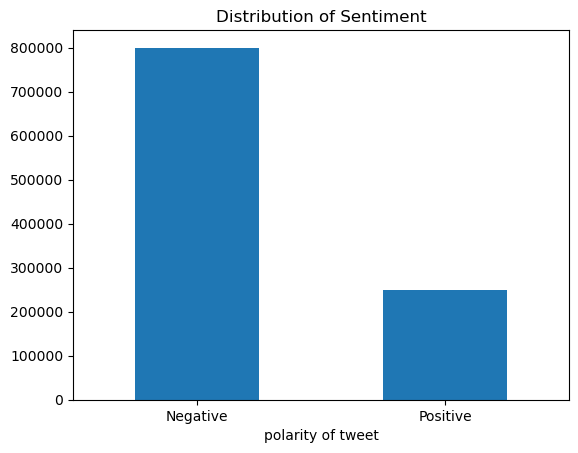

In [5]:
# Selecting necessary columns
data = data[['polarity of tweet','text of the tweet']]

# Replacing values for better understanding (assuming 4 represents positive sentiment)
data['polarity of tweet'] = data['polarity of tweet'].replace(4, 1)

# Plotting the distribution of data
ax = data.groupby('polarity of tweet').count().plot(
    kind='bar',
    title='Distribution of Sentiment',
    legend=False
)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

# Storing data in lists
text = list(data['text of the tweet'])
sentiment = list(data['polarity of tweet'])


# Preprocessing

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

Lower Casing: Each text is converted to lowercase.
Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
Removing Short Words: Words with length less than 2 are removed.
Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)


In [6]:
#Preprocessing
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [7]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # Loop through each tweet in the input data
    for tweet in textdata:
        # Convert the tweet to lowercase
        tweet = tweet.lower()
        
        # Replace all URLs with 'URL'
        tweet = re.sub(urlPattern, 'URL', tweet)
        
        # Replace all emojis with their corresponding label (assuming 'emojis' is a dictionary)
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        
        # Replace @USERNAME mentions with 'USER'
        tweet = re.sub(userPattern, 'USER', tweet)
        
        # Replace all non-alphanumeric characters with a space
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replace 3 or more consecutive letters with 2 letters
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        # Tokenize the tweet by splitting it into words
        for word in tweet.split():
            # Check if the word's length is greater than 1
            if len(word) > 1:
                # Lemmatize the word
                word = wordLemm.lemmatize(word)
                tweetwords += (word + ' ')
            
        processedText.append(tweetwords)
        
    return processedText


In [8]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 82 seconds


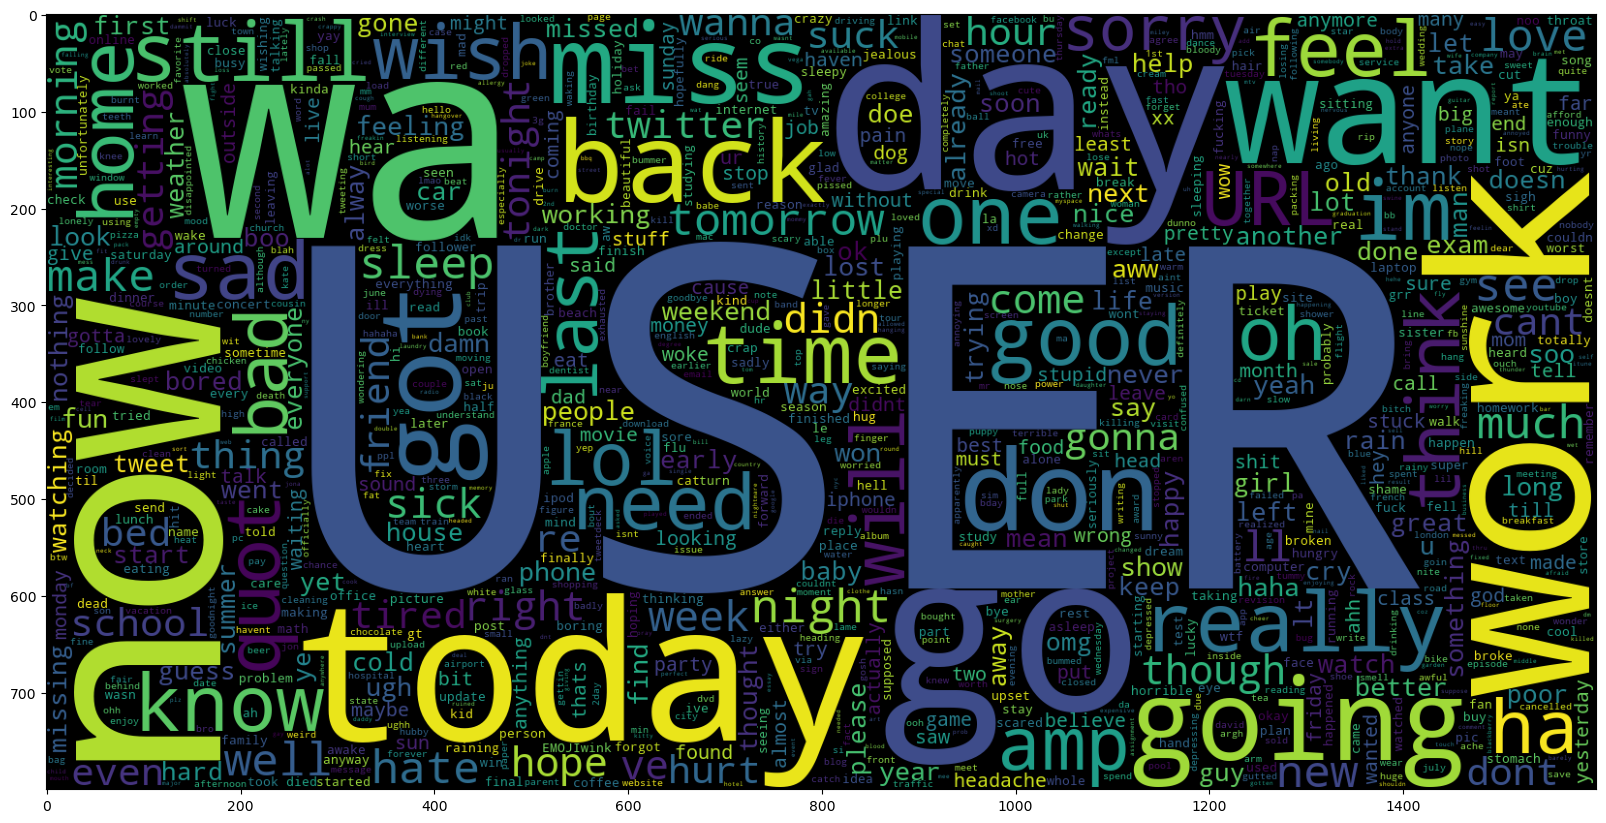

In [9]:
#word cloud for negative data
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

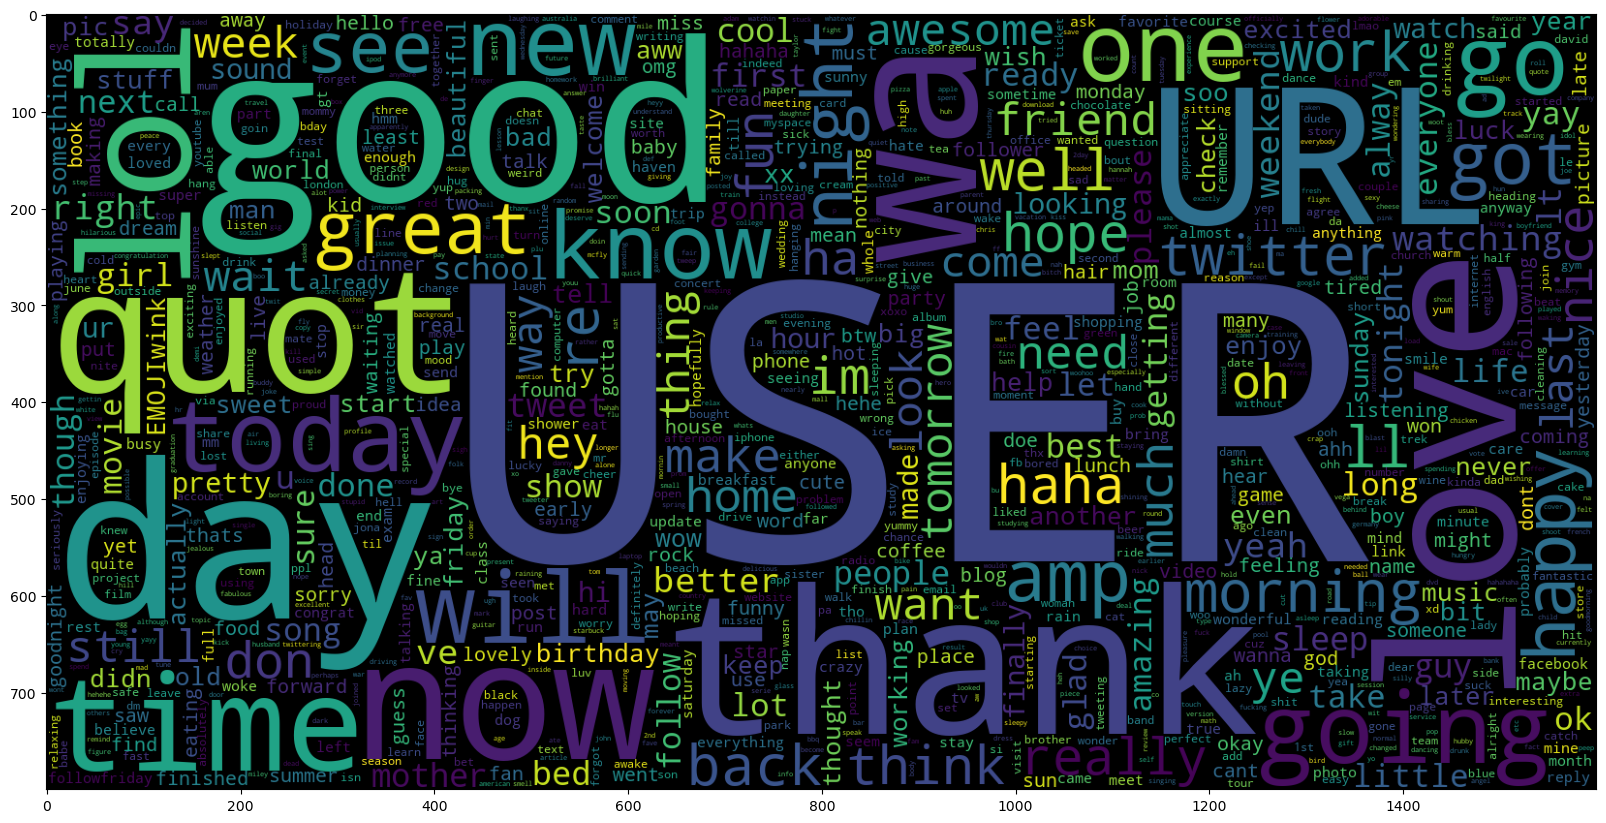

In [10]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [11]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
print('Vectorizer fitted.')
print('No. of feature words: ', len(vectorizer.get_feature_names_out()))


Vectorizer fitted.
No. of feature words:  500000


In [14]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [15]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.86      0.93      0.90    159862
           1       0.71      0.52      0.60     49853

    accuracy                           0.84    209715
   macro avg       0.79      0.73      0.75    209715
weighted avg       0.83      0.84      0.83    209715



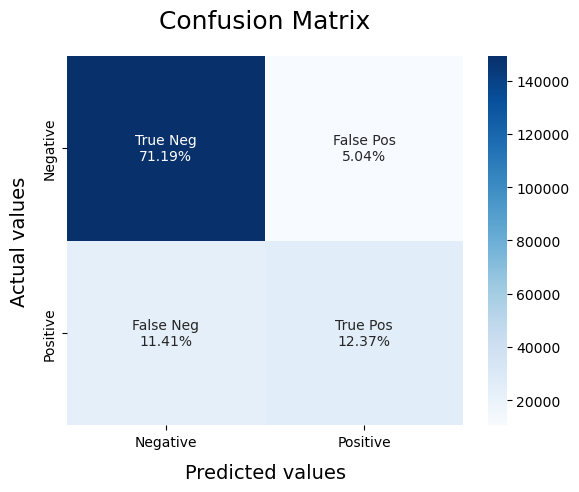

In [16]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

C:\Users\Abhishek Ramola\Desktop\Python\Aiml\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.93      0.91    159862
           1       0.73      0.62      0.67     49853

    accuracy                           0.86    209715
   macro avg       0.81      0.78      0.79    209715
weighted avg       0.85      0.86      0.85    209715



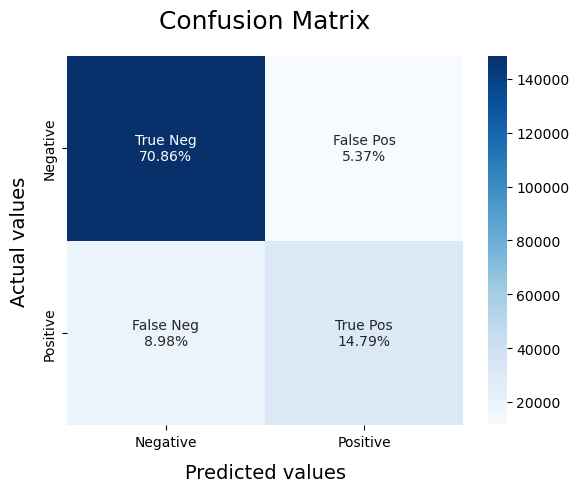

In [17]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91    159862
           1       0.78      0.60      0.68     49853

    accuracy                           0.87    209715
   macro avg       0.83      0.78      0.80    209715
weighted avg       0.86      0.87      0.86    209715



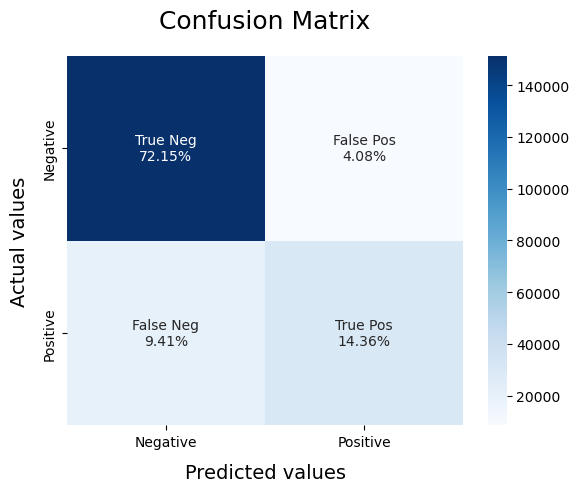

In [18]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [29]:
LRmodel.score(X_test,y_test)
LRmodel.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectorizer, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('preprocess.pickle','wb')
pickle.dump(preprocess, file)
file.close()

# Using the Model.
To use the model for Sentiment Prediction we need to import the Vectoriser and LR Model using Pickle.

The vectoriser can be used to transform data to matrix of TF-IDF Features. While the model can be used to predict the sentiment of the transformed Data. The text whose sentiment has to be predicted however must be preprocessed.

In [28]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectorizer, LRmodel

def predict(vectorizer, model, text):
    # Predict the sentiment
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["bitch give me ",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(vectorizer, LRmodel, text)
    print(df.head())


                              text sentiment
0                   bitch give me   Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative
